#**CNN for morphological classifation of galaxies **





This code was developed as part of the optative lecture 'Data analysis for astronomy' held at the UNAM Astronomy Institute during the fall 2023 term.

Teachers:
* Jorge Barrera
* Joel Sanchez

Students:
* Eric Macías Estrada
* Mónica Alejandra Villa Durango
* Valeria Quintero Ortega
* Aurora Mata Sánchez



Uno de los focos de estudio de la astrofísica son las galaxias, ya que en estos cuerpos celestes se llevan a cabo numerosos procesos cruciales para la comprensión del universo. Un ejemplo muy importante es la formación y evolución estelar así como la evolución cosmológica del universo.

En 1936, Edward Hubble propuso un sistema para clasificar las galaxias según sus características morfológicas, conocido actualmente como el Diagrama de Hubble. Este diagrama se divide en cuatro categorías principales: elípticas, espirales barradas, espirales y lenticulares. Sin embargo, más allá de la clasificación morfológica de las galaxias, este diagrama permite tener una clasificación según sus propiedades físicas como la dinámica interna, población estelar, formación estelar y presencia de gas [Duprey & Kolano 2014](https://api.semanticscholar.org/CorpusID:6429673).

Existen varios métodos de clasificación de galaxias, por ejemplo de forma numérica principalmente mediante su perfil de brillo superficial [Herrmann et al., 2013](https://iopscience.iop.org/article/10.3847/0004-6256/151/6/145/meta). Sin embargo se requiere hacer un ajuste individual para cada objeto, lo cual lo hace ineficiente. Por otro lado, os modelos de machine learning han mostrado ser una herramienta muy eficaz para realizar muchas tareas computacionales, especialmente en problemas de clasificación.


En este proyecto realizamos una red neuronal convolucional basados en el trabajo realizado por [Gharat & Dandawate (2021)](https://doi.org/10.1093/mnras/stac457). Esta red hace una clasificación morfólogica de 10 tipos de galaxias diferentes.

Hacemos uso de AstroNN, un paquete de Python que permite crear varios tipos de redes neuronales aptas para aplicar en astronomía, Astro NN nos provee datos del SDSS Galaxy10 Dataset y es capaz de manejar imágenes en 2D, los datos ya se encuetran reducidos y clasificados para una mejor lectura de estos. Desarrollamos la red neuronal por medio de Tensorflow y Keras API como modelo y prototipo de entrenamiento.

Trabajamos con otras librerías básicas como Numpy y Pylab.

Este script se ejecutó en Colab usando la GPU de colab.

---

* [Documentación AstroNN](http://astronn.readthedocs.io/)


## Procedimiento:

Iniciamos con unos renglones para verificar la instalación de las librerías que necesitamos para entrenar nuestro modelo.

In [ ]:
!pip install tensorflow
!pip install tensorflow_probability
!pip install git+https://github.com/henrysky/astroNN.git

  Cloning https://github.com/henrysky/astroNN.git to /tmp/pip-req-build-hbzvo2h8
  Running command git clone --filter=blob:none --quiet https://github.com/henrysky/astroNN.git /tmp/pip-req-build-hbzvo2h8
  Resolved https://github.com/henrysky/astroNN.git to commit 294dd6775550adc9aaece7355b72d3b2f1d9ed8f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 23.3 MB/s eta 0:00:00
  Created wheel for astroNN: filename=astroNN-1.2.dev0-py3-none-any.whl size=9336512 sha256=bc2cf372604d0f58341533df3b709676de241fe8c1f6c0286db5b4c0fd5a5277
  Stored in directory: /tmp/pip-ephem-wheel-cache-fc9vnclq/wheels/22/d1/2b/2a4d4d76da90d8da884392aae60ad54592660343cb5b8942c7
Successfully built astroNN


En esta parte importamos las paqueterías y funciones necesarias para construir nuestro modelo.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pylab as plt
from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as cns
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from tensorflow.keras import optimizers

Descargamos y guardamos los datos de AstroNN, también los labels para clasificación

In [ ]:
#Descarga de datos

images, labels = load_galaxy10sdss()


# Conversión de los labels en 10 clases categoricas

labels = utils.to_categorical(labels, 10)


Galaxy10.h5:  97%|█████████▋| 204M/210M [00:02<00:00, 74.3MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:03, 52.9MB/s]                           


En la base de datos de galaxy 10 encontramos la clasificación morfologica de las galaxias en 10 diferentes tipos, las cuales se muestra a continuación y son las que buscamos clasificar.


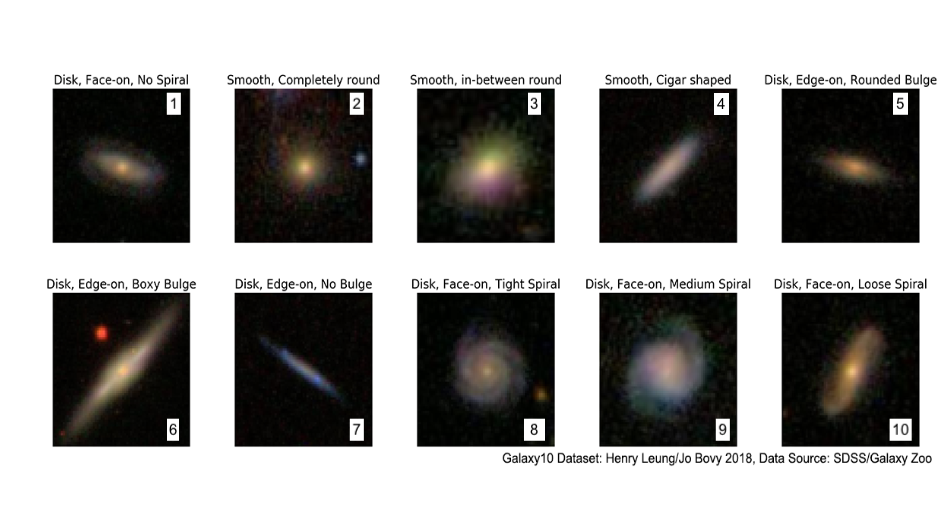

Para preparar los datos convertimos nuestras imágenes y sus etiquetas en numeros flotantes para poder usarlos. Dividimos los datos entre los de entrenamiento y prueba.

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
#Estandarización
images=images/255

In [ ]:
##Preparacion de los datos

# Convertir el tipo de variable

labels = labels.astype(np.float32)
images = images.astype(np.float32)

# Se dividen los datos entre los datos de entrenamiento 80% y de prueba 20%

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), train_size=0.8, test_size=0.2)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

Es importante que las variables que entran a la red se encuentren dentro de un rango similar, para evitar que las variable de rango mayor tengan mayor influencia en el modelo que las demas. También al utilizar funciones que mapean la recta real en un rango entre -1 y 1, si las variables son muy grandes, las imágenes de tangente hiperbólica no distingue diferencias si estas tienen grandes valores.

Al entrenar nuestro modelo encontramos que existía un sobreajuste, por lo que decidimos incluir una estandarización y agregar algunas capas de dropout para mejorar nuestro modelo.

En esta parte definimos nuestro modelo. Usamos un total de 4 capas convolucionales, tres maxpooling, tres dropout, tres densas y un flatten.

Definiendo cada una:

* Convolucional: Esta es la capa más importante porque realiza la operación entre un arreglo de píxeles que se ingresa (Imagen) y un arreglo más pequeño (filtro) el cual va ralizando un barrido a través de toda la imagen, sumando y ponderando cada una de sus entradas. Con esto, la convolución es es capaz de identificar características o patrones dentro del arreglo dado, estos son tomados por el filtro y se muestran en la imagen convolucionada. La composicíon de distintos filtros a lo largo de varias capas permite reconocer características complejas.

* Pooling: Permite reducir el tamaño de los arreglos sin perder las caracteŕısticas esenciales detectables. En este caso se realiza un barrido con una ventana que toma un valor dado de los elementos que cubre (generalmente el máximo o el promedio) y genera un nuevo arreglo cuyas entradas son esos nuevos valores.

* Flatten: Esta operación toma el arreglo 2D que ya ha sido procesado para la extracción de características y ordena sus filas de tal forma que se genera un arreglo 1D.


Para nuestro modelo, empezamos con dos capas convolucionales de 64 filtros y un kernel de 3x3, con la forma de nuestra imagen de 69x69 pixeles y 3 filtros de color.
Después tenemos otras tres capas de Pooling, para reducir el tamaño de los mapas de convolución, alternadas entre otras dos capas de convolución. Luego una capa de Dropout para eliminar el 50% de las neuronas y una de Flatten para ponerlo en un vector. Luego otras dos capas de redes neuronales con funciones de activación "tanh", alternadas con otras dos capas de Dropout, del 30% cada una. Se hizo uso de esta función de activación porque ha mostrado mejor desempeño que la función "Relu" (ver [Szandała, T. (2021)](https://link.springer.com/chapter/10.1007/978-981-15-5495-7_11)). Finalmente una capa de 10 neuronas (número de clasificaciones que queremos) para la salida con una función de activación de "Softmax".

In [ ]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(69, 69, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(150, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(60, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    #que te da sobreajuste, muchas epocas, split, complejidad
    #que te quita, dropout, pocas epocas, regularizar penaliza que los pesos sean muy grandes, ||W|| es la suma de todos los pesos, regularización L2, 0.001 learning rate de la regularización
    #acotada y no lineal, tanh de -1 y 1, cerca del cero es lineal, y permite tomar valores negativos
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

Aqui mostramos el resumen del modelo:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 65, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       2

In [ ]:
#resumen de los datos a entrenar
np.histogram(train_labels.argmax(axis=1))[0]

array([2764, 5573, 5079,  280, 1211,   16,  479,  891,  728,  407])

In [ ]:
#Usamos checkpoint para poder guardar algunos de los valores de los pesos  en algun intervalo para poder continuar con el entrenamiento después
checkpoint = ModelCheckpoint(filepath='mejores_pesos', monitor='val_loss', save_best_only=True)

En este paso entrenamos el modelo, definimos un learning rate y usamos "cross entropy" como métrica para ver la precisión de los datos, como se especifica en el artículo. Definimos las épocas y el batch que queremos usar, así como el porcentaje que usaremos para validación que es 20%.



In [ ]:
#Copilacion del modelo
lr = 0.001  # rata de entrenamiento
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optimizers.Adam(learning_rate=lr))
#Guarda el modelo para poder hacer las gráficas

#Entrenamiento del modelo
history = model.fit(train_images, train_labels, epochs=200, batch_size=64, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/200
218/218 [==============================] - 14s 55ms/step - loss: 1.3631 - accuracy: 0.5067 - val_loss: 1.2273 - val_accuracy: 0.5866
Epoch 2/200
218/218 [==============================] - 12s 56ms/step - loss: 1.2504 - accuracy: 0.5672 - val_loss: 1.1321 - val_accuracy: 0.6489
Epoch 3/200
218/218 [==============================] - 11s 52ms/step - loss: 1.1689 - accuracy: 0.6186 - val_loss: 1.0873 - val_accuracy: 0.6581
Epoch 4/200
218/218 [==============================] - 11s 52ms/step - loss: 1.0965 - accuracy: 0.6577 - val_loss: 1.0135 - val_accuracy: 0.6627
Epoch 5/200
218/218 [==============================] - 11s 51ms/step - loss: 1.0222 - accuracy: 0.6940 - val_loss: 0.9285 - val_accuracy: 0.7260
Epoch 6/200
218/218 [==============================] - 11s 50ms/step - loss: 0.9986 - accuracy: 0.7029 - val_loss: 0.8939 - val_accuracy: 0.7413
Epoch 7/200
218/218 [==============================] - 11s 51ms/step - loss: 0.9607 - accuracy: 0.7158 - val_loss: 0.8919 - val_ac

El modelo alcanza en la época 60 un valor de accuracy de 0.8072. Ya con nuestro modelo entrenado accedemos nuestros datos, tanto de pérdida como de validación y graficamos.

<ipython-input-19-e142f18118b1>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
<ipython-input-19-e142f18118b1>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-.b" (-> color='b'). The keyword argument will take precedence.
<ipython-input-19-e142f18118b1>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
<ipython-input-19-e142f18118b1>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-.r" (-> color='r'). The keyword argument will take precedence.


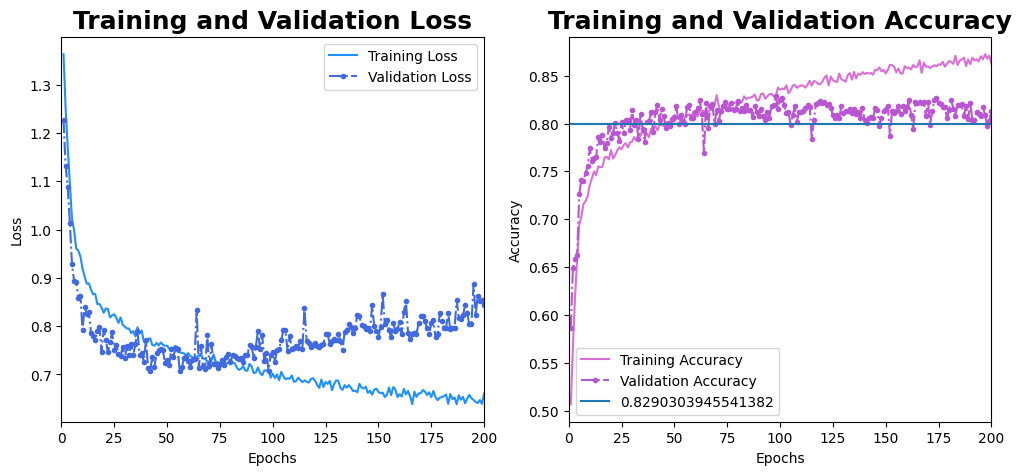

In [ ]:
# Accede a la pérdida y la precisión en el conjunto de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Grafica la pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss',color='dodgerblue')
plt.plot(epochs, val_loss, '.-.b', label='Validation Loss',color='royalblue')
plt.title('Training and Validation Loss', size=18,weight="bold")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0,200)
plt.legend()

# Grafica la precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r', label='Training Accuracy',color='orchid')
plt.plot(epochs, val_accuracy, '.-.r', label='Validation Accuracy',color='mediumorchid')
plt.plot((0,max(epochs)),(0.8,0.8), label = np.max(val_accuracy))
plt.title('Training and Validation Accuracy',size=18, weight="bold")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0,200)
plt.legend()


Podemos observar que nuestro training acccuracy o precisión alcanza a sobrepasar ligeramente el ~80% y se mantiene oscilando al rededor del 80% con un valor máximo del 82% en una de las épocas finales. La pérdida alcanza un valor menor a 0.8, tomando un mínimo en 0.63. En la grafica de accuracy (derecha) la línea horizontal azul se muestra para poder visualizar mejor los valores superiores al 80%.

In [ ]:
#Evaluacion del modelo
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

137/137 [==============================] - 1s 8ms/step - loss: 0.8506 - accuracy: 0.8006


In [ ]:
# Hacer predicciones
predictions = model.predict(test_images)

# Convertir las predicciones a etiquetas

predicted_labels = np.argmax(predictions, axis=1)
test_class = np.argmax(test_labels, axis=1)


# create the confusion matrix
confusion_matrix = np.zeros((10,10))
for counter, i in enumerate(predicted_labels):

    confusion_matrix[i, test_class[counter]] += 1

#galaxy10_confusion(confusion_matrix)

137/137 [==============================] - 1s 6ms/step


Construimos una matriz de confusión, esta nos muestra los aciertos y errores en clasificación entre nuestros valores reales y los valores de predicción.

In [ ]:
def plot_cm(Y_reales,Y_predichos, labels, porcentaje=False):
    #Generamos la matriz de confusión a partir de los dos arreglos
    matrix = sklearn.metrics.confusion_matrix(Y_reales.argmax(axis=1), Y_predichos.argmax(axis=1))

    #plt.title("Confusion matrix ",size=15)
    #Aquí se divide si la queremos en porcentaje o en números
    cmapc  = 'RdPu'
    if porcentaje==False:
      ax = cns.heatmap(matrix, annot=True, cmap= cmapc, cbar_kws={'label': 'scale of successes'})
      plt.title("Confusion matrix (successes)",size=25,weight="bold")
    if porcentaje==True:
        plt.title("Confusion matrix (percentage)",size=25,weight="bold")
        m=np.zeros(matrix.shape)
        for j in range(0,matrix.shape[1]):
            m[:,j]=matrix[:,j]/np.sum(matrix[:,j])
        ax = cns.heatmap(m, annot=True,fmt='.2%',
                                          cmap= cmapc, cbar_kws={'label': 'scale of percentage'})

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.set(xlabel="True label", ylabel="Predicted label")

Graficamos dos matrices de confusión, a la izquierda tenemos la matriz con el número de etiquetas que logramos clasificar correctamente y a la derecha el porcentaje de aciertos. Igualmente podemos observar las clasificaciones erradas y su porcentaje.

137/137 [==============================] - 1s 7ms/step


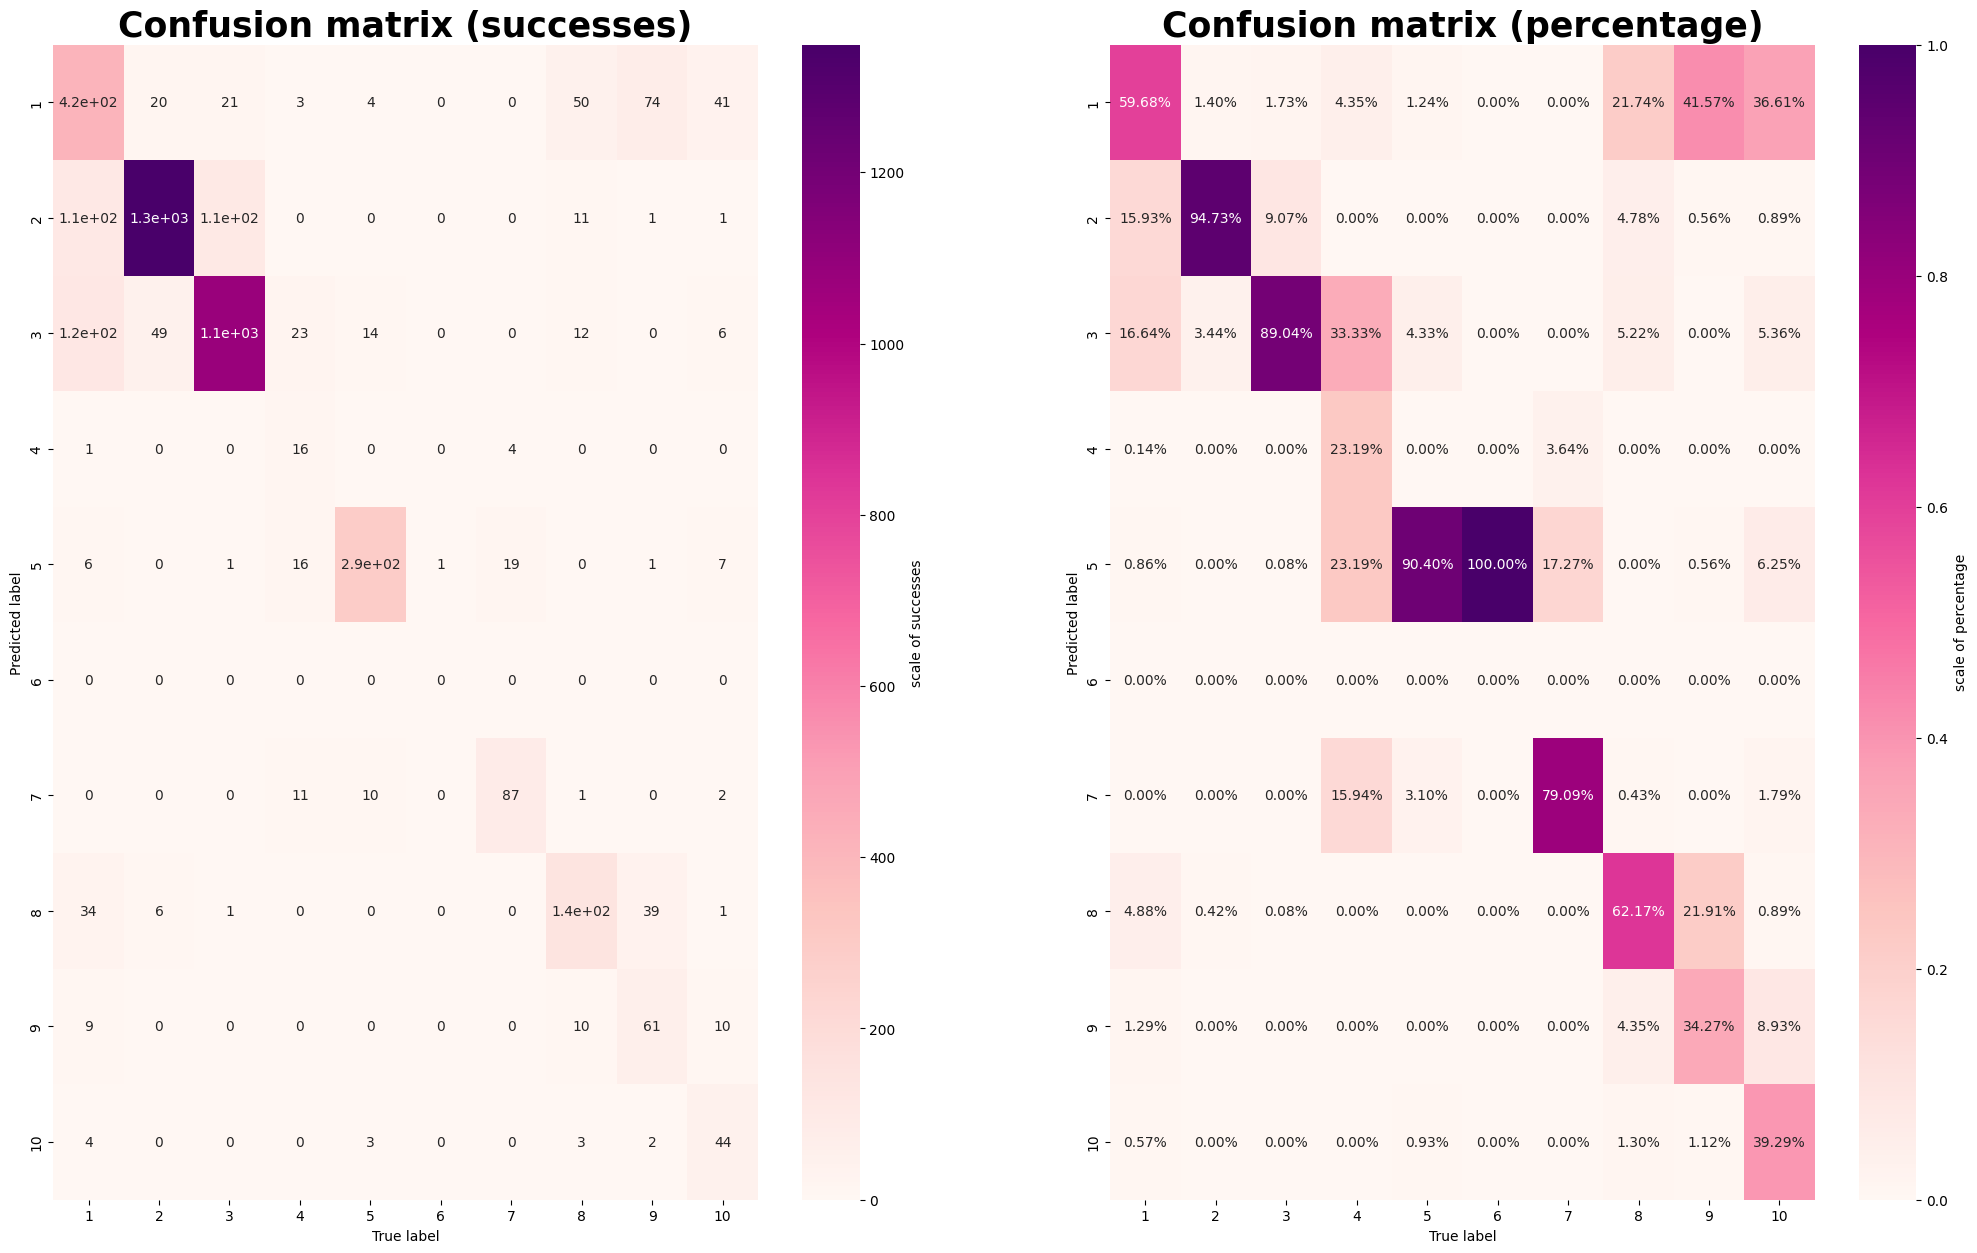

In [ ]:
plt.figure(figsize=(25,15))

plt.subplot(1, 2, 1)
labels=['1','2', '3', '4', '5', '6', '7', '8', '9', '10']
plot_cm(model.predict(test_images),test_labels, labels, porcentaje=False)

plt.subplot(1,2,2)
labels=['1','2', '3', '4', '5', '6', '7', '8', '9', '10']
plot_cm(model.predict(test_images),test_labels, labels, porcentaje=True)

Podemos observar que los tipos 2, 3 y 5 (las galaxias con un bulbo mas esférico) fueron las que lograron una mejor clasificación, alccanzando valores por encima del ~90%. Los resultados están acorde con los obtenidos en el artículo donde las mejores clasificaciones fueron 1, 2 y 4 (en el artículo las etiquetas son de 0-9). Sin embargo, en las galaxias tipo 6 no obtuvimos ninguna clasificación correcta, esto debido a que se tiene muy pocas galaxias de este tipo en la muestra. Si nos fijamos bien, algunas de los resultados erroneos se deben a la similitud de la morfología de las galaxias, por ejemplo, aunque morfoĺogicamente las lenticulares se ven como un disco y las elípticas son tri-axiales, en algunas de las imágenes ambas lucen muy similares por el punto de vista debido a que no presentan estructuras como brazos o un bulbo definido. Por otro lado, las espirales y las espirales barradas tienen muchas características en común y algunas veces su barra no es perceptible. Posiblemente con imágenes de mayor resolución o con un mejor método se pueda hacer una clasificación más exacta de estas galaxias.